# Unbalanced Optimal Transport

This tutorial shows how to use OTT to compute the solution of an unbalanced Optimal Transport (OT) problem using the Sinkhorn algorithm. The unbalanced OT problem with an entropic regularization is defined as : 
$$\arg \min_{P>0} \langle P,C \rangle - \varepsilon \text{KL}(P|ab^T) + \rho_a \text{KL}(P\textbf{1}_m|a) + \rho_b \text{KL}(P^T\textbf{1}_n|b)$$
where $\rho_a$ and $\rho_b$ regularize how strictly the OT constraints are met and $\varepsilon$ accounts for the entropic regularization.
The adapted Sinkhorn algorithm is detailed in {cite}`sejourne:23`.
Instead of $\rho_a$ and $\rho_b$, the `sinkhorn` function uses parameters $\text{tau_a}=\rho_a /(\varepsilon+ \rho_a)$ and $\text{tau_b}=\rho_b /(\varepsilon+ \rho_b)$. Setting either of these parameters to 1 corresponds to setting the corresponding $\rho_a, \rho_b$ to $\infty$ and solving the corresponding balanced OT problem. 

## Librairies 

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Generate source and target distributions

Let us first generate the source and target distributions that correspond to the illustrative exemple of {cite}`sejourne:23` (Figure 4). The corresponding plots can be visualized below.  

In [2]:
def gaussian_mixture(means, scales, number_samples, rng):
    rngs = jax.random.split(rng, len(means))
    mixture = [
        scales[i] * jax.random.normal(rngs[i], (number_samples[i], 2))
        + means[i]
        for i in range(len(means))
    ]
    return jnp.concatenate(mixture)

In [3]:
rng = jax.random.PRNGKey(0)
rng_source, rng = jax.random.split(rng, 2)
means_source = [
    jnp.array([[-1.6, -1.6]]),
    jnp.array([[-1, 0.25]]),
    jnp.array([[0.25, -1]]),
    jnp.array([[0.25, 1]]),
    jnp.array([[1, 0.25]]),
]
scale_source = [0.1] * 5
number_samples_source = [8] * 5
source = gaussian_mixture(
    means_source, scale_source, number_samples_source, rng_source
)

rng_target, rng = jax.random.split(rng, 2)
means_target = [
    jnp.array([[1.6, 1.6]]),
    jnp.array([[-1, -0.25]]),
    jnp.array([[-0.25, -1]]),
    jnp.array([[-0.25, 1]]),
    jnp.array([[1, -0.25]]),
]
scale_target = [0.1] * 5
number_samples_target = [8] * 5
target = gaussian_mixture(
    means_target, scale_target, number_samples_target, rng_target
)

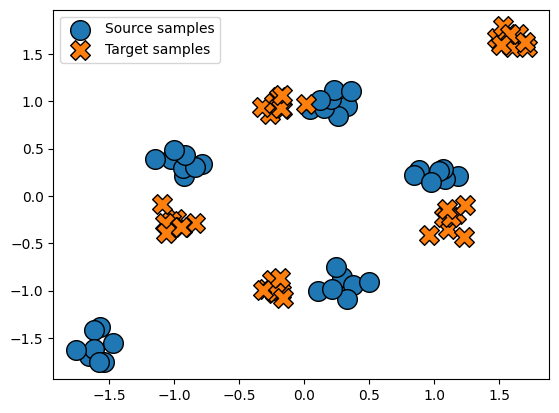

In [4]:
def plot_samples(source, target):
    plt.scatter(
        source[:, 0],
        source[:, 1],
        s=200,
        edgecolors="k",
        marker="o",
        label="Source samples",
    )
    plt.scatter(
        target[:, 0],
        target[:, 1],
        s=200,
        edgecolors="k",
        marker="X",
        label="Target samples",
    )
    plt.legend()
    plt.show()


plot_samples(source, target)

The source and target distributions are both a mixture of five gaussians. One can observe that the central four modes from the source can be naturally matched to the central four modes from the target while in each distribution the fifth mode is distant and can be seen as outliers.

Let us first visualize the result of the balanced OT in this setting.

## Balanced OT mapping

Solving the balanced OT problem is equivalent to fixing `tau_a`=`tau_b`=`1.0`.

In [5]:
# Define an euclidean geometry with epsilon=5e-4
geom = pointcloud.PointCloud(source, target, epsilon=5e-4)

In [6]:
# Define a linear problem associated to the geometry defined above and tau_a = tau_b = 1.0
ot_prob = linear_problem.LinearProblem(geom, tau_a=1.0, tau_b=1.0)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)

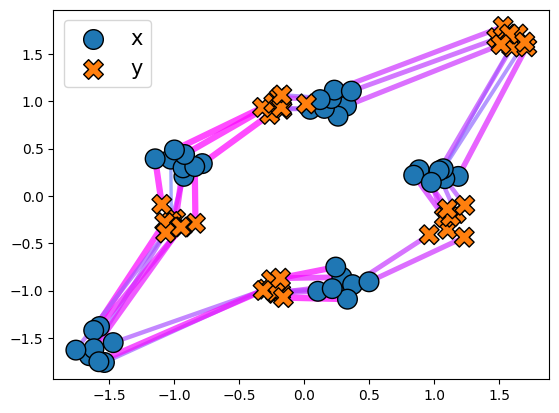

In [7]:
# Plot the computed transport plan
plott = ott.tools.plot.Plot(cost_threshold=1e-2)
_ = plott(ot)

In the solution of the balanced OT problem, the outliers interact with the other points. This is not suitable in several applications. The more natural mapping discussed previously can be computed by solving the unbalanced OT problem.

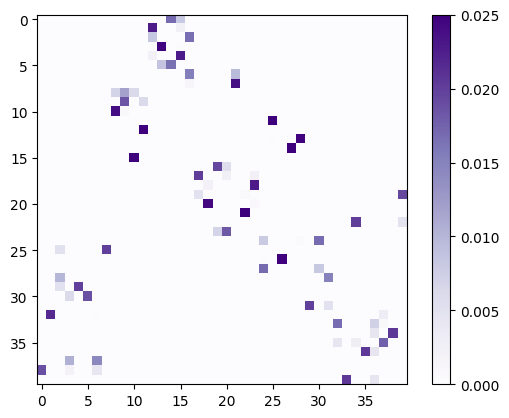

In [8]:
# Plot the OT matrix
P = ot.matrix
plt.imshow(P, cmap="Purples")
plt.colorbar();

## Unbalanced OT mapping

In [9]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom, tau_a=1 - 1e-3, tau_b=1 - 1e-3)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)

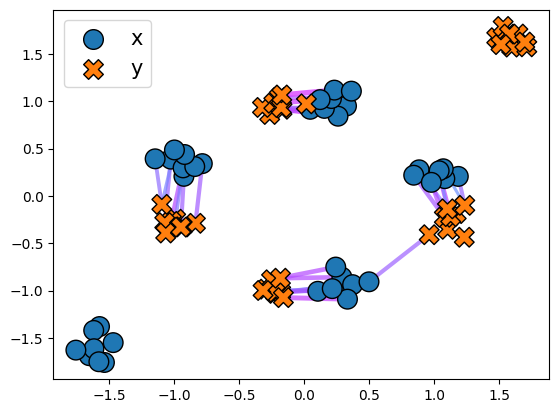

In [10]:
plott = ott.tools.plot.Plot(cost_threshold=1e-2)
_ = plott(ot)

This solution is the one that was expected. The four matching correspond to the four clusters that can be observed when plotting the OT matrix.

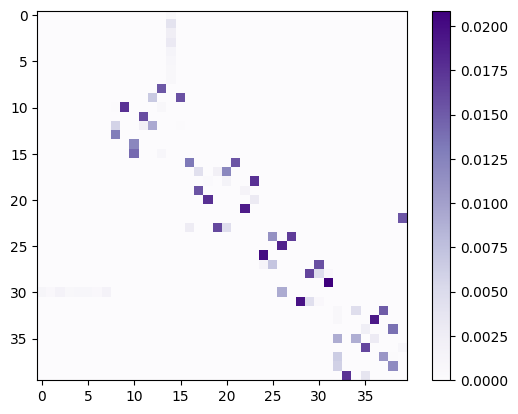

In [11]:
# you can instantiate the OT matrix
P = ot.matrix
plt.imshow(P, cmap="Purples")
plt.colorbar();